In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from model import GalerkinSARIMA
import time

In [2]:
# Generate toy datasets (for testing)
np.random.seed(123)
n = 300
t = np.arange(n)

# A: Noisy ARMA(2,1)
phi_true = [0.6, -0.3]
theta_true = [0.5]
eps = np.random.normal(scale=1.0, size=n)
y_a = np.zeros(n)
for i in range(2, n):
    y_a[i] = (phi_true[0] * y_a[i-1] + phi_true[1] * y_a[i-2] + theta_true[0] * eps[i-1] + eps[i])

# B: Seasonal sine + noise (period m=20)
y_b = np.sin(2 * np.pi * t / 20) + 0.5 * np.random.normal(size=n)

# C: Linear trend + AR(1)
eps_c = np.random.normal(scale=0.5, size=n)
y_c = np.zeros(n)
for i in range(1, n):
    y_c[i] = 0.01 * i + 0.8 * y_c[i-1] + eps_c[i]

# D: Nonlinear (Logistic map) + noise
r = 3.8
eps_d = np.random.normal(scale=0.02, size=n)
y_d = np.zeros(n)
y_d[0] = 0.4
for i in range(1, n):
    y_d[i] = r * y_d[i-1] * (1 - y_d[i-1]) + eps_d[i]

datasets = {
    'Noisy_ARMA': y_a,
    'Seasonal': y_b,
    'Trend_AR': y_c,
    'Nonlinear': y_d
}


In [3]:


window = 20
horizon = 100
num_runs = 1
p_values = [0,1,5]
q_values = [0,1,5]
P_values = [0]
Q_values = [0]
m_seasonal = 5

orders = [(p, q, P, Q) for p in p_values for q in q_values for P in P_values for Q in Q_values]


In [4]:

all_results = []
first_run_preds = {}  # Store predictions from first run for plotting

# Import ARIMA from statsmodels
try:
    from statsmodels.tsa.arima.model import ARIMA
    has_statsmodels = True
except ImportError:
    print("Warning: statsmodels not available, ARIMA will be skipped")
    has_statsmodels = False

# Define algorithms to run
algorithms = [
    {'name': 'GARIMA-OLS', 'use_ridge': False},
    {'name': 'GARIMA-Ridge', 'use_ridge': True, 'ridge_lambda_ar': 1.5, 'ridge_lambda_ma': 1.0, 
     'ridge_weight_scheme': 'poly', 'ridge_eta': 1.5},
]

if has_statsmodels:
    algorithms.append({'name': 'ARIMA', 'is_statsmodels': True})

for run in range(1, num_runs + 1):
    runs_left = num_runs - run
    print(f"\n=== Run {run}/{num_runs}  (runs left after this: {runs_left}) ===")

    for name, series in datasets.items():
        m = m_seasonal

        for p, q, P, Q in tqdm(orders, desc=f"Param combos for {name}", total=len(orders), leave=False):
            y_true = series[window:window + horizon]
            
            # Run each algorithm
            for alg_config in algorithms:
                alg_name = alg_config['name']
                preds = []
                iter_times = []
                
                combo_start = time.perf_counter()
                
                for i in range(window, window + horizon):
                    t0 = time.perf_counter()
                    train = series[:i]
                    
                    try:
                        if alg_config.get('is_statsmodels', False):
                            # ARIMA from statsmodels
                            model = ARIMA(train, order=(p, 0, q), seasonal_order=(P, 0, Q, m))
                            model_fit = model.fit()
                            pred = model_fit.forecast(steps=4)
                            preds.append(pred)
                        else:
                            # GalerkinSARIMA (OLS or Ridge)
                            model = GalerkinSARIMA(
                                train, 
                                order=(p, 0, q), 
                                seasonal_order=(P, 0, Q, m), 
                                basis_functions=["quadratic", "sigmoid", "linear"],
                                forecast_method="direct",
                                use_ridge=alg_config['use_ridge'],
                                ridge_lambda_ar=alg_config.get('ridge_lambda_ar', 1.0),
                                ridge_lambda_ma=alg_config.get('ridge_lambda_ma', 1.0),
                                ridge_weight_scheme=alg_config.get('ridge_weight_scheme', 'none'),
                                ridge_eta=alg_config.get('ridge_eta', 1.0),
                                standardize=True
                            )
                            model.fit(train)
                            pred = model.forecast(steps=4)
                            preds.append(pred)
                    except Exception as e:
                        # If fitting fails, append NaNs
                        print(f"Warning: {alg_name} failed for {name} at iteration {i}: {e}")
                        preds.append(np.full(4, np.nan))
                    
                    iter_times.append(time.perf_counter() - t0)
                
                combo_sec = time.perf_counter() - combo_start
                
                preds = np.array(preds)
                # Extract only the last step of each multi-step forecast
                last_step_preds = preds[:, -1] if preds.ndim > 1 else preds
                
                # Store predictions from first run for plotting
                if run == 1:
                    first_run_preds[(name, p, q, P, Q, alg_name)] = last_step_preds
                
                # Calculate metrics
                mask = ~np.isnan(last_step_preds)
                mae = mean_absolute_error(y_true[mask], last_step_preds[mask]) if mask.any() else np.nan
                rmse = np.sqrt(mean_squared_error(y_true[mask], last_step_preds[mask])) if mask.any() else np.nan
                
                # Timing stats
                mean_iter_ms = float(np.mean(iter_times)) * 1000 if len(iter_times) else np.nan
                median_iter_ms = float(np.median(iter_times)) * 1000 if len(iter_times) else np.nan
                max_iter_ms = float(np.max(iter_times)) * 1000 if len(iter_times) else np.nan
                throughput_iters_per_sec = (len(iter_times) / combo_sec) if combo_sec > 0 else np.nan
                
                all_results.append([
                    name, p, q, P, Q, run, alg_name,
                    mae, rmse,
                    mean_iter_ms, median_iter_ms, max_iter_ms,
                    combo_sec, len(iter_times), throughput_iters_per_sec
                ])

# Aggregate and print for verification (timing columns included)
df = pd.DataFrame(
    all_results,
    columns=[
        'Dataset', 'p', 'q', 'P', 'Q', 'Run', 'Alg',
        'MAE', 'RMSE',
        'mean_iter_ms', 'median_iter_ms', 'max_iter_ms',
        'combo_sec', 'num_iters', 'throughput_iters_per_sec'
    ]
)
agg = df.groupby(['Dataset', 'p', 'q', 'P', 'Q', 'Alg'], as_index=False).mean()

print("\nAveraged over {} runs (including timing):\n".format(num_runs))
print(agg.to_markdown(index=False))


=== Run 1/1  (runs left after this: 0) ===


Param combos for Noisy_ARMA:  11%|█         | 1/9 [00:00<00:06,  1.30it/s]/Users/liuhaojie/Desktop/Galerkin_ARIMA/.conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
Param combos for Noisy_ARMA:  22%|██▏       | 2/9 [00:01<00:07,  1.04s/it]/Users/liuhaojie/Desktop/Galerkin_ARIMA/.conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/liuhaojie/Desktop/Galerkin_ARIMA/.conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/liuhaojie/Desktop/Galerkin_ARIMA/.conda/lib/python3.1


Averaged over 1 runs (including timing):

| Dataset    |   p |   q |   P |   Q | Alg          |   Run |       MAE |     RMSE |   mean_iter_ms |   median_iter_ms |   max_iter_ms |   combo_sec |   num_iters |   throughput_iters_per_sec |
|:-----------|----:|----:|----:|----:|:-------------|------:|----------:|---------:|---------------:|-----------------:|--------------:|------------:|------------:|---------------------------:|
| Noisy_ARMA |   0 |   0 |   0 |   0 | ARIMA        |     1 | 1.33378   | 1.68266  |       6.22739  |         6.12733  |       9.29771 |   0.622769  |         100 |                  160.573   |
| Noisy_ARMA |   0 |   0 |   0 |   0 | GARIMA-OLS   |     1 | 1.3354    | 1.68606  |       0.67148  |         0.669209 |       1.347   |   0.0671769 |         100 |                 1488.61    |
| Noisy_ARMA |   0 |   0 |   0 |   0 | GARIMA-Ridge |     1 | 1.3354    | 1.68606  |       0.758442 |         0.734833 |       1.2585  |   0.0758574 |         100 |                 

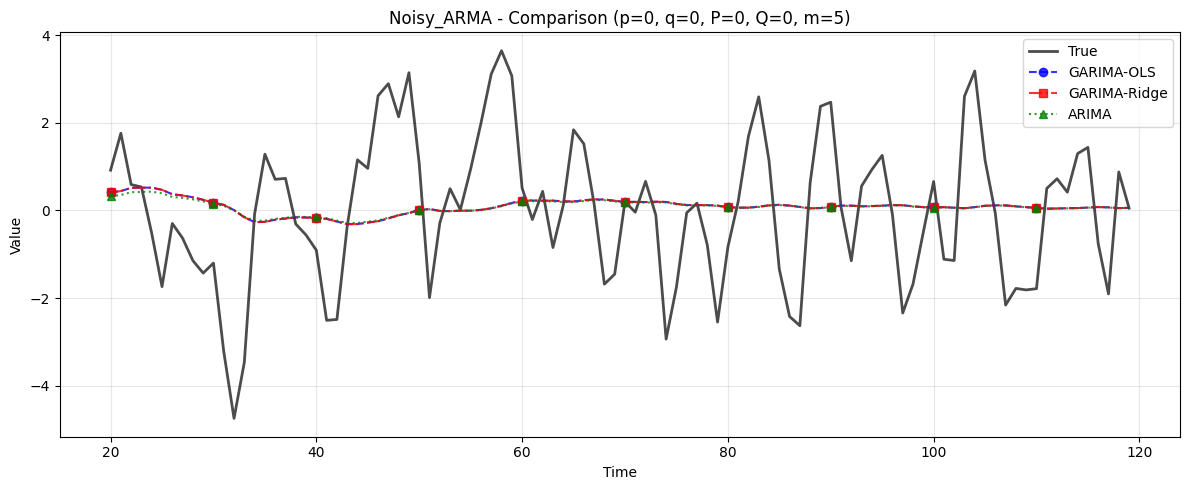


Noisy_ARMA (p=0, q=0, P=0, Q=0):
  ARIMA           - MAE: 1.3338, RMSE: 1.6827, Time: 0.62s
  GARIMA-OLS      - MAE: 1.3354, RMSE: 1.6861, Time: 0.07s
  GARIMA-Ridge    - MAE: 1.3354, RMSE: 1.6861, Time: 0.08s



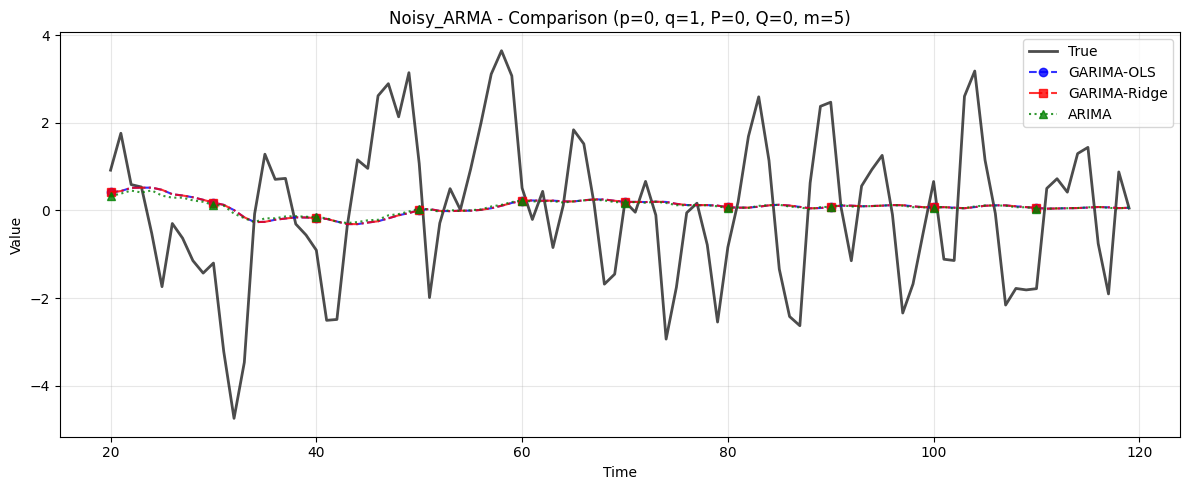


Noisy_ARMA (p=0, q=1, P=0, Q=0):
  ARIMA           - MAE: 1.3238, RMSE: 1.6688, Time: 0.96s
  GARIMA-OLS      - MAE: 1.3354, RMSE: 1.6861, Time: 0.11s
  GARIMA-Ridge    - MAE: 1.3354, RMSE: 1.6861, Time: 0.16s



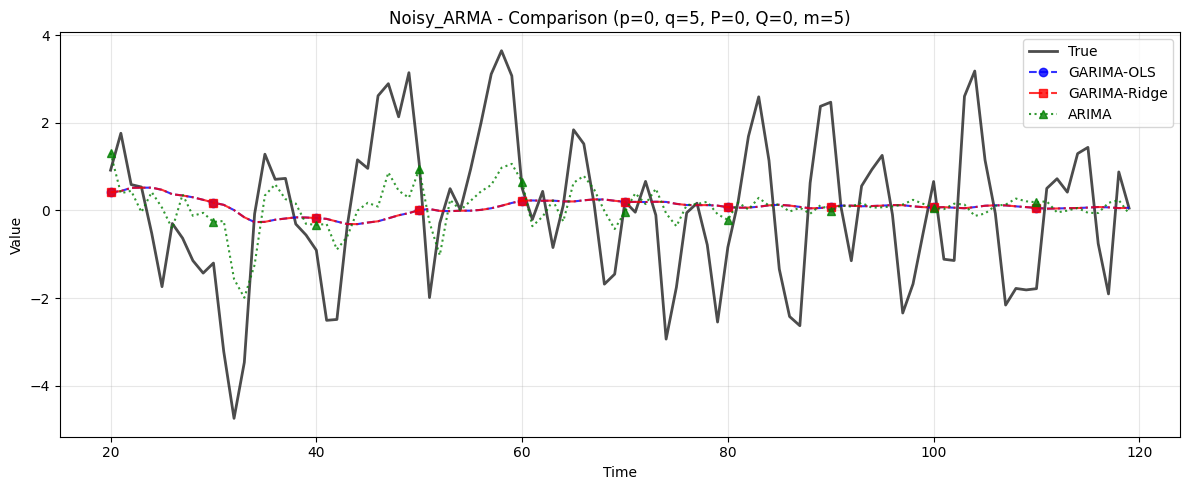


Noisy_ARMA (p=0, q=5, P=0, Q=0):
  ARIMA           - MAE: 1.1850, RMSE: 1.4688, Time: 2.68s
  GARIMA-OLS      - MAE: 1.3354, RMSE: 1.6861, Time: 0.15s
  GARIMA-Ridge    - MAE: 1.3354, RMSE: 1.6861, Time: 0.26s



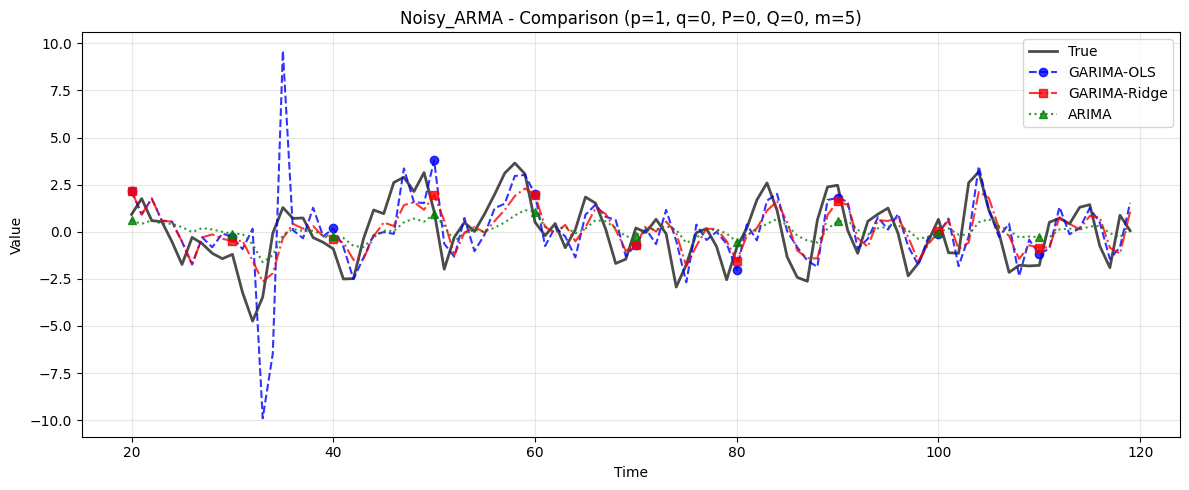


Noisy_ARMA (p=1, q=0, P=0, Q=0):
  ARIMA           - MAE: 1.2034, RMSE: 1.4751, Time: 0.63s
  GARIMA-OLS      - MAE: 1.2386, RMSE: 1.7882, Time: 0.16s
  GARIMA-Ridge    - MAE: 1.0756, RMSE: 1.2877, Time: 0.21s



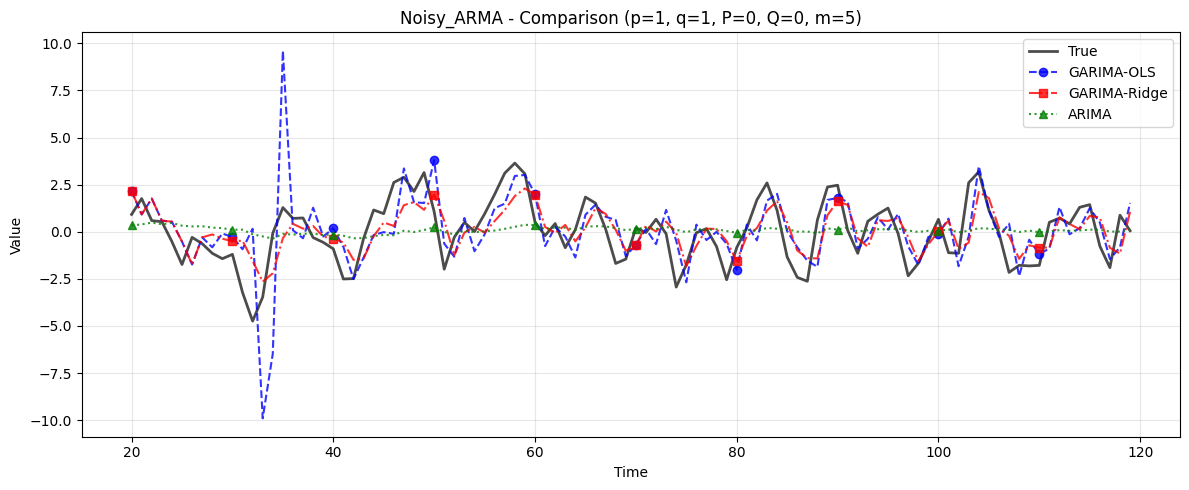


Noisy_ARMA (p=1, q=1, P=0, Q=0):
  ARIMA           - MAE: 1.2926, RMSE: 1.6269, Time: 1.11s
  GARIMA-OLS      - MAE: 1.2386, RMSE: 1.7882, Time: 0.20s
  GARIMA-Ridge    - MAE: 1.0756, RMSE: 1.2877, Time: 0.27s



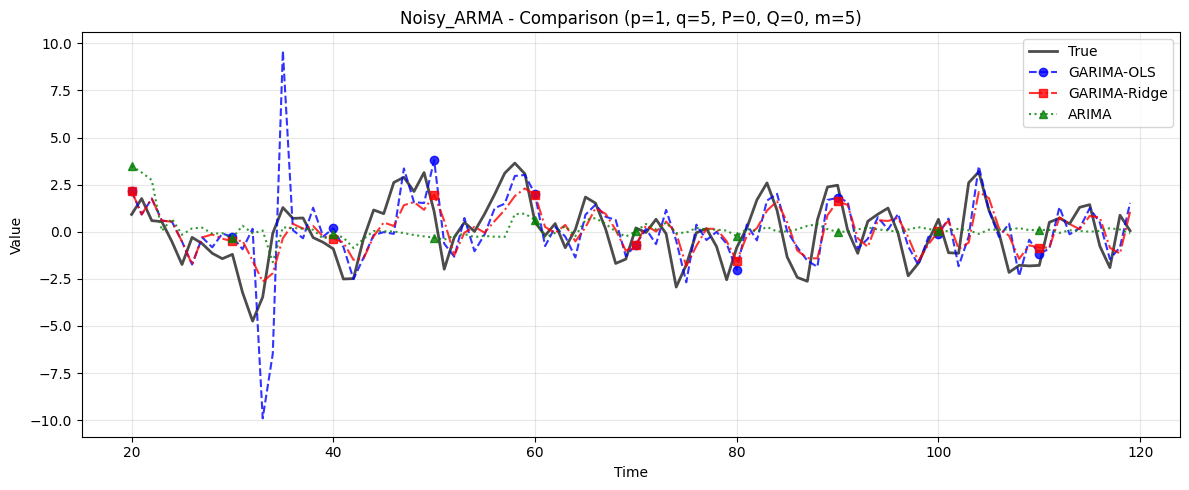


Noisy_ARMA (p=1, q=5, P=0, Q=0):
  ARIMA           - MAE: 1.3347, RMSE: 1.6671, Time: 5.50s
  GARIMA-OLS      - MAE: 1.2386, RMSE: 1.7882, Time: 0.24s
  GARIMA-Ridge    - MAE: 1.0756, RMSE: 1.2877, Time: 0.30s



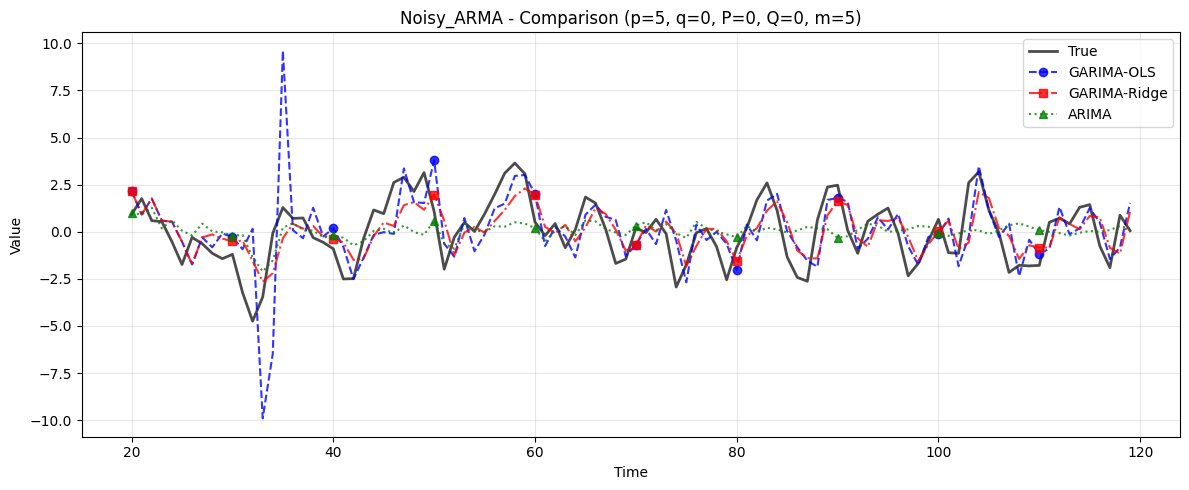


Noisy_ARMA (p=5, q=0, P=0, Q=0):
  ARIMA           - MAE: 1.2349, RMSE: 1.5408, Time: 1.67s
  GARIMA-OLS      - MAE: 1.2386, RMSE: 1.7882, Time: 0.20s
  GARIMA-Ridge    - MAE: 1.0756, RMSE: 1.2877, Time: 0.24s



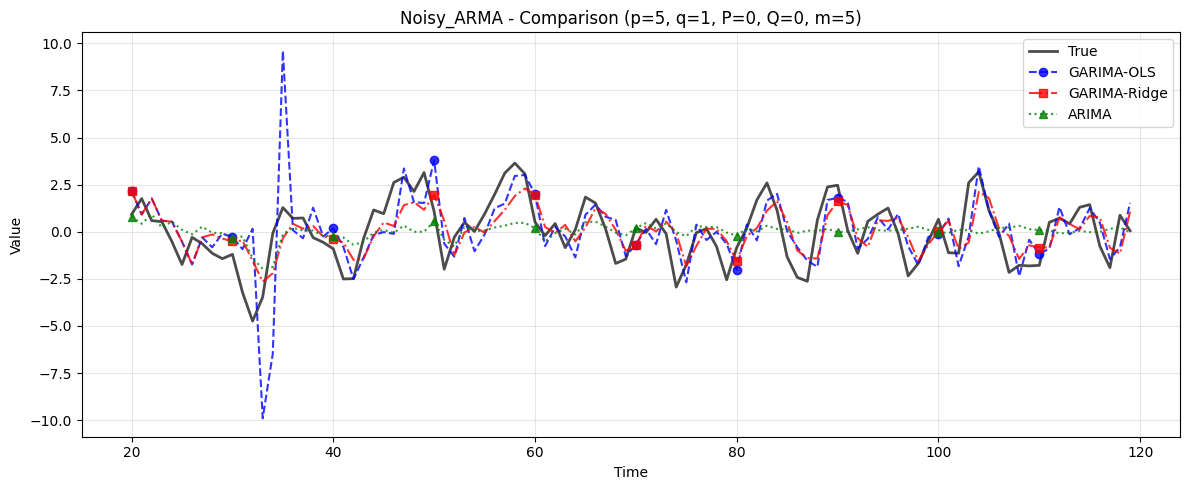


Noisy_ARMA (p=5, q=1, P=0, Q=0):
  ARIMA           - MAE: 1.2413, RMSE: 1.5373, Time: 3.08s
  GARIMA-OLS      - MAE: 1.2386, RMSE: 1.7882, Time: 0.23s
  GARIMA-Ridge    - MAE: 1.0756, RMSE: 1.2877, Time: 0.29s



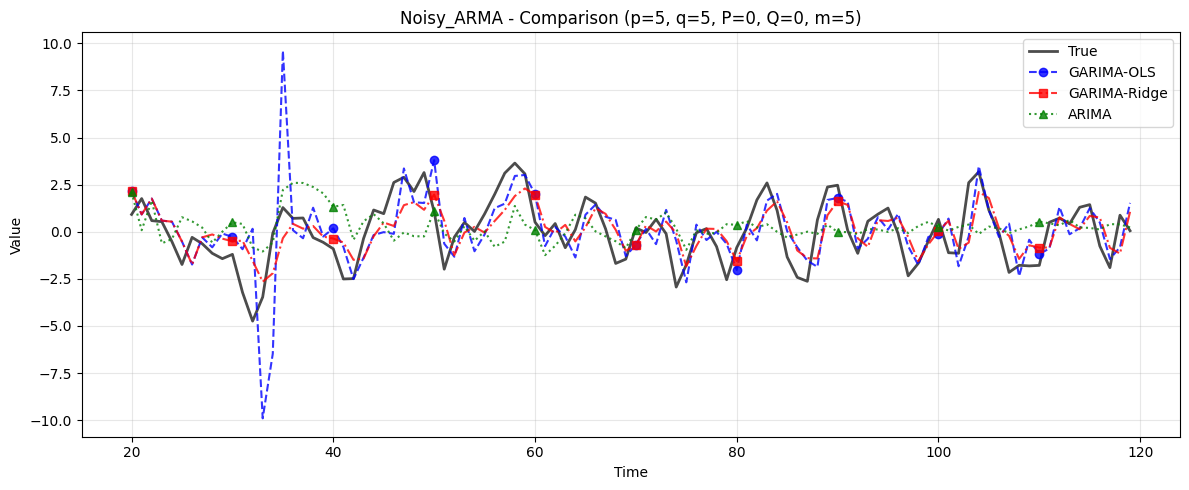


Noisy_ARMA (p=5, q=5, P=0, Q=0):
  ARIMA           - MAE: 1.4084, RMSE: 1.7331, Time: 11.15s
  GARIMA-OLS      - MAE: 1.2386, RMSE: 1.7882, Time: 0.27s
  GARIMA-Ridge    - MAE: 1.0756, RMSE: 1.2877, Time: 0.30s



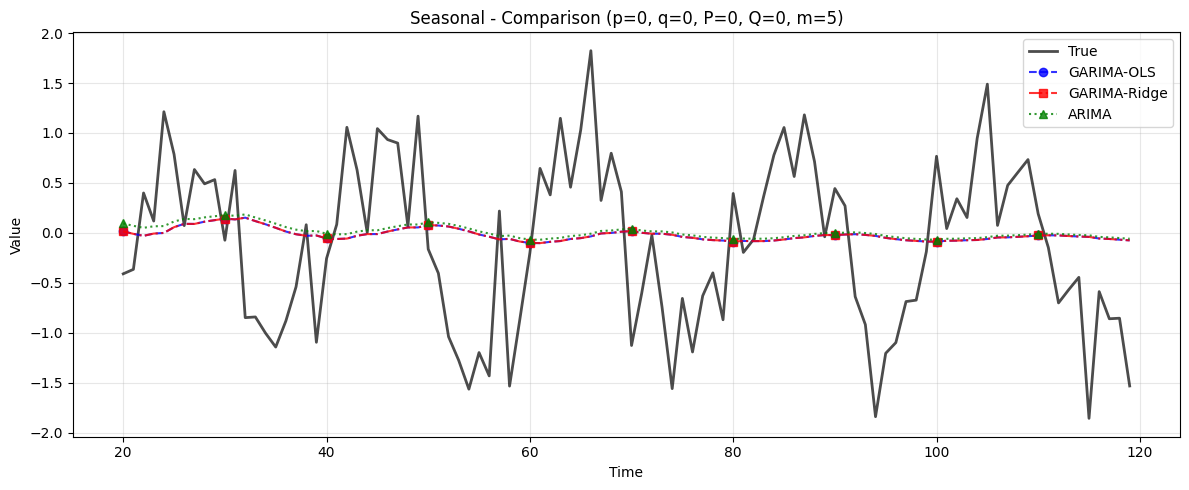


Seasonal (p=0, q=0, P=0, Q=0):
  ARIMA           - MAE: 0.6993, RMSE: 0.8362, Time: 0.69s
  GARIMA-OLS      - MAE: 0.6991, RMSE: 0.8340, Time: 0.07s
  GARIMA-Ridge    - MAE: 0.6991, RMSE: 0.8340, Time: 0.08s



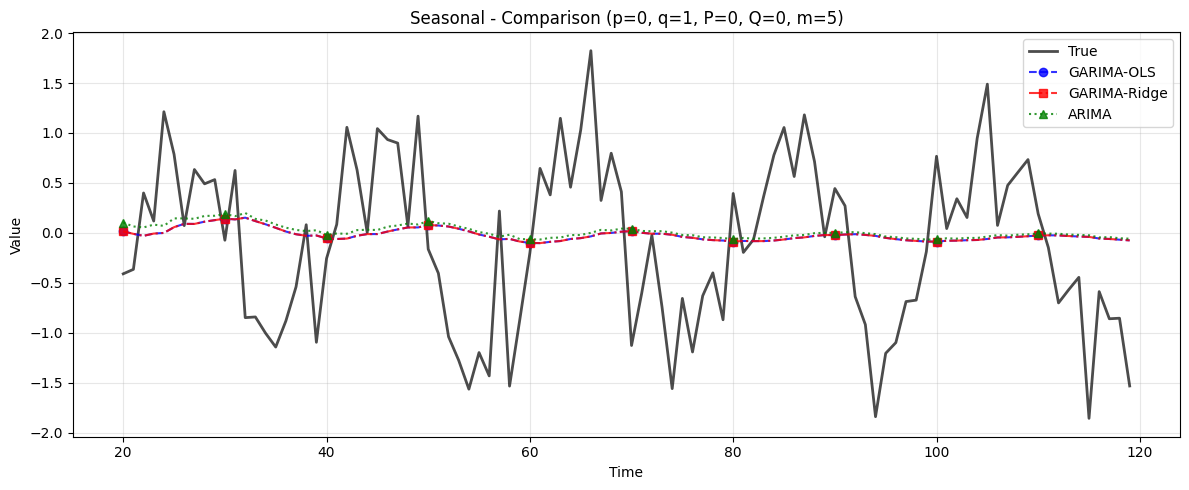


Seasonal (p=0, q=1, P=0, Q=0):
  ARIMA           - MAE: 0.6969, RMSE: 0.8340, Time: 0.66s
  GARIMA-OLS      - MAE: 0.6991, RMSE: 0.8340, Time: 0.11s
  GARIMA-Ridge    - MAE: 0.6991, RMSE: 0.8340, Time: 0.16s



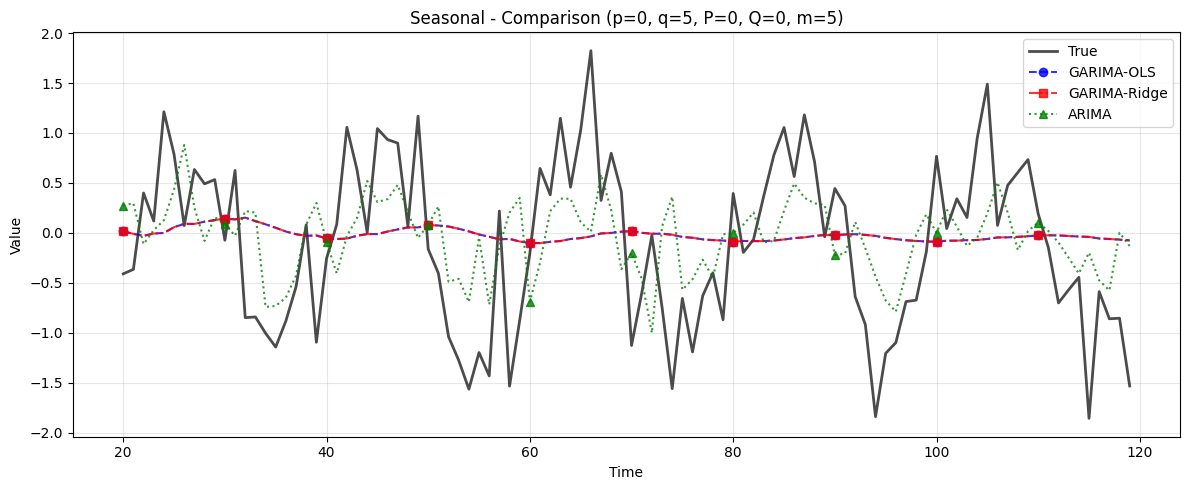


Seasonal (p=0, q=5, P=0, Q=0):
  ARIMA           - MAE: 0.6119, RMSE: 0.7414, Time: 3.38s
  GARIMA-OLS      - MAE: 0.6991, RMSE: 0.8340, Time: 0.15s
  GARIMA-Ridge    - MAE: 0.6991, RMSE: 0.8340, Time: 0.15s



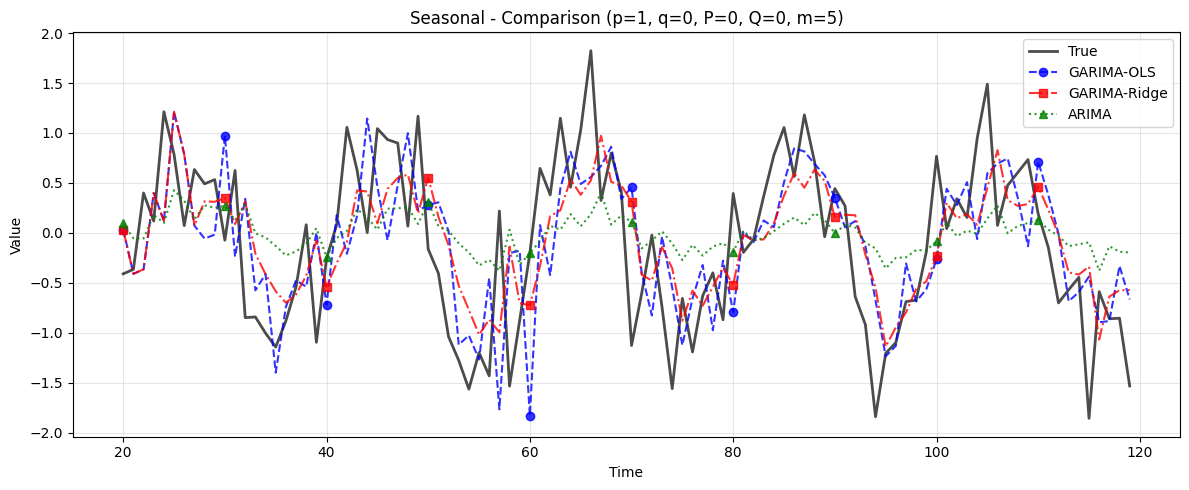


Seasonal (p=1, q=0, P=0, Q=0):
  ARIMA           - MAE: 0.6227, RMSE: 0.7532, Time: 0.63s
  GARIMA-OLS      - MAE: 0.5890, RMSE: 0.7183, Time: 0.16s
  GARIMA-Ridge    - MAE: 0.5278, RMSE: 0.6468, Time: 0.21s



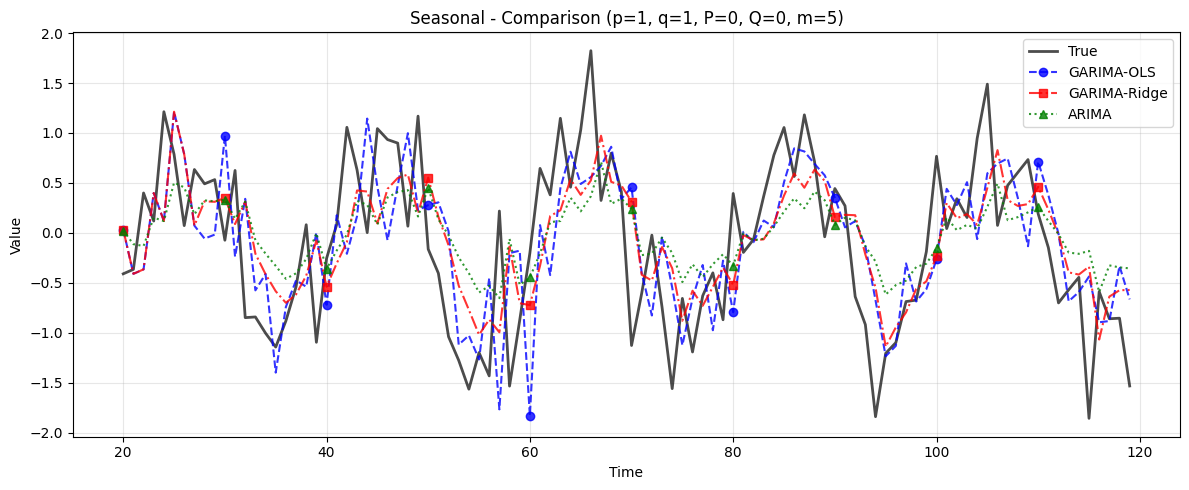


Seasonal (p=1, q=1, P=0, Q=0):
  ARIMA           - MAE: 0.5686, RMSE: 0.6909, Time: 1.02s
  GARIMA-OLS      - MAE: 0.5890, RMSE: 0.7183, Time: 0.21s
  GARIMA-Ridge    - MAE: 0.5278, RMSE: 0.6468, Time: 0.27s



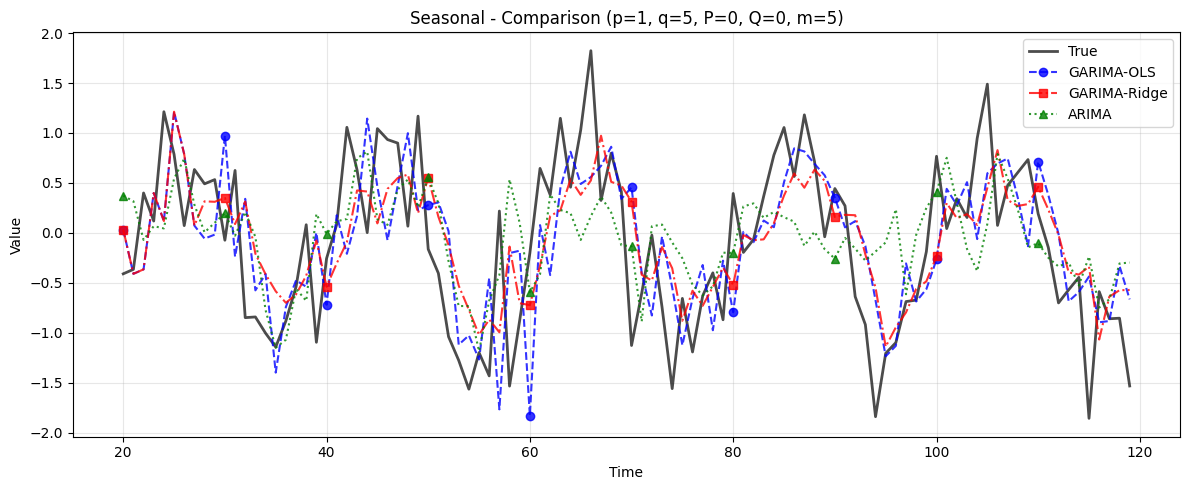


Seasonal (p=1, q=5, P=0, Q=0):
  ARIMA           - MAE: 0.6055, RMSE: 0.7467, Time: 5.80s
  GARIMA-OLS      - MAE: 0.5890, RMSE: 0.7183, Time: 0.24s
  GARIMA-Ridge    - MAE: 0.5278, RMSE: 0.6468, Time: 0.30s



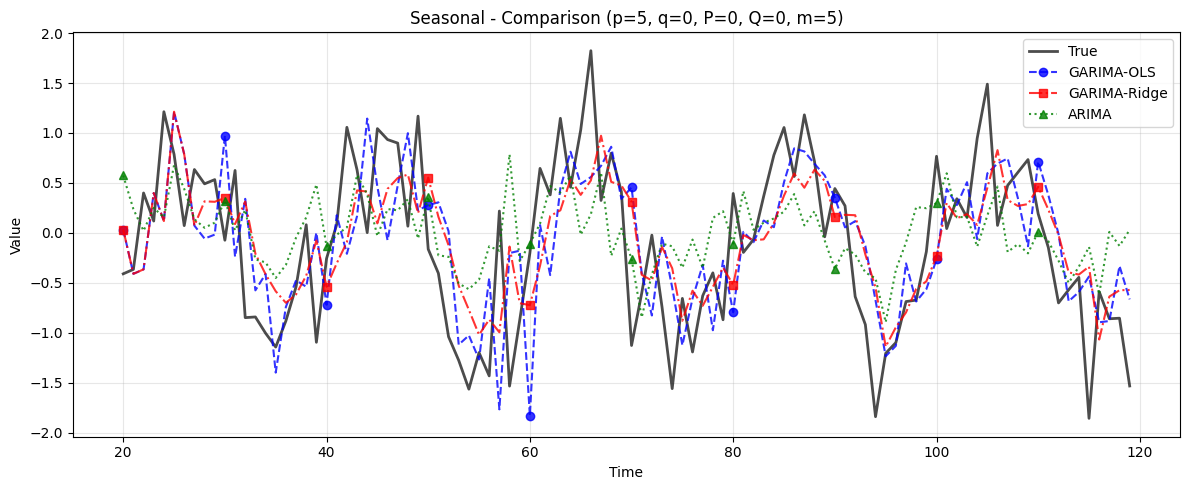


Seasonal (p=5, q=0, P=0, Q=0):
  ARIMA           - MAE: 0.6218, RMSE: 0.7617, Time: 1.59s
  GARIMA-OLS      - MAE: 0.5890, RMSE: 0.7183, Time: 0.20s
  GARIMA-Ridge    - MAE: 0.5278, RMSE: 0.6468, Time: 0.24s



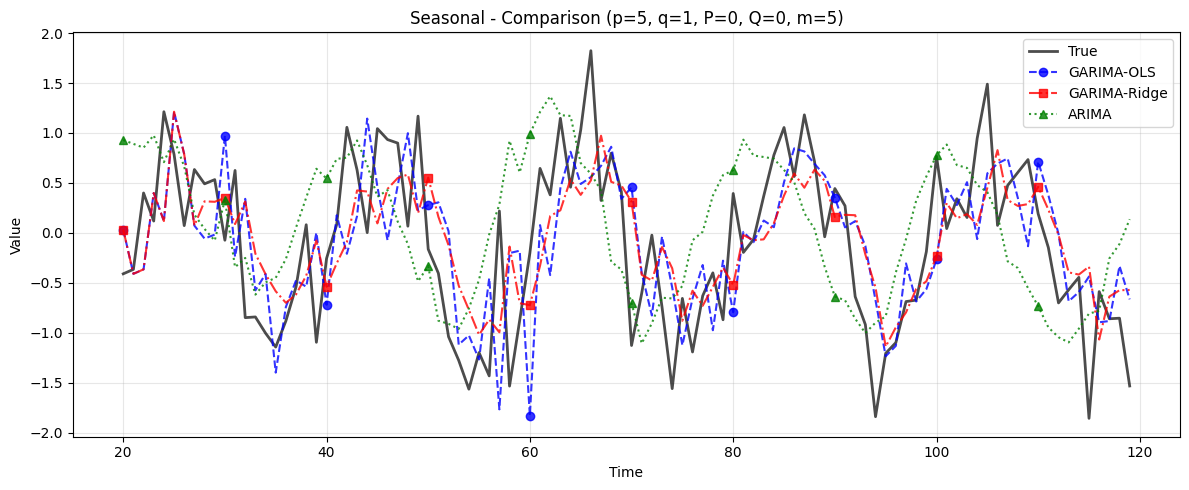


Seasonal (p=5, q=1, P=0, Q=0):
  ARIMA           - MAE: 0.6724, RMSE: 0.8028, Time: 6.81s
  GARIMA-OLS      - MAE: 0.5890, RMSE: 0.7183, Time: 0.24s
  GARIMA-Ridge    - MAE: 0.5278, RMSE: 0.6468, Time: 0.29s



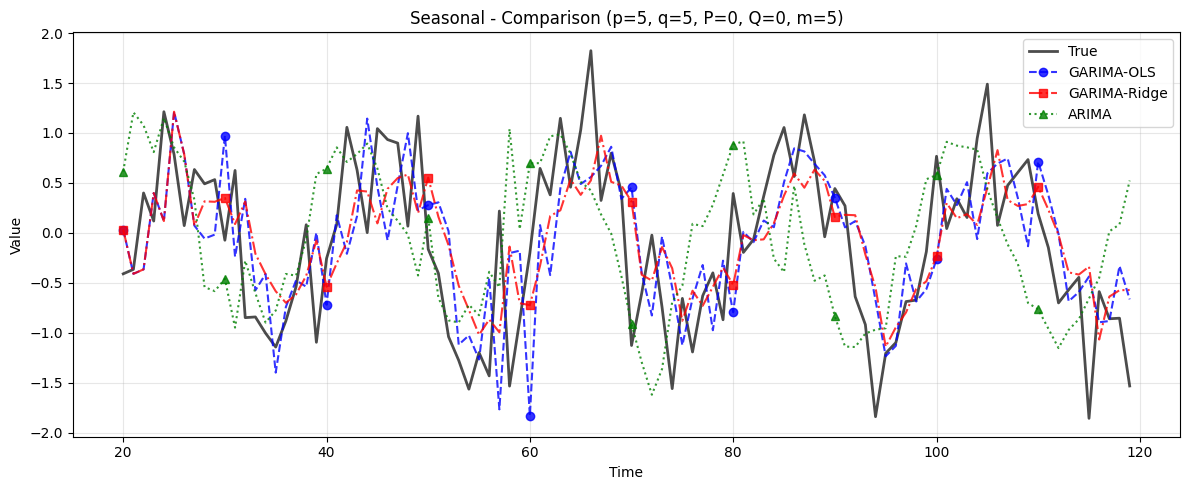


Seasonal (p=5, q=5, P=0, Q=0):
  ARIMA           - MAE: 0.7023, RMSE: 0.8590, Time: 11.71s
  GARIMA-OLS      - MAE: 0.5890, RMSE: 0.7183, Time: 0.27s
  GARIMA-Ridge    - MAE: 0.5278, RMSE: 0.6468, Time: 0.31s



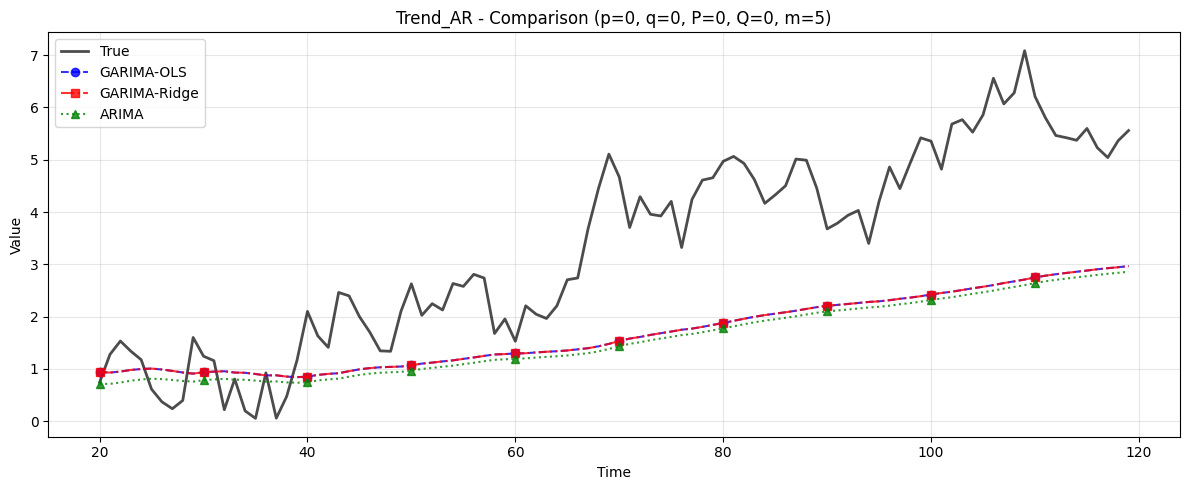


Trend_AR (p=0, q=0, P=0, Q=0):
  ARIMA           - MAE: 1.8379, RMSE: 2.1489, Time: 0.61s
  GARIMA-OLS      - MAE: 1.7560, RMSE: 2.0650, Time: 0.06s
  GARIMA-Ridge    - MAE: 1.7560, RMSE: 2.0650, Time: 0.07s



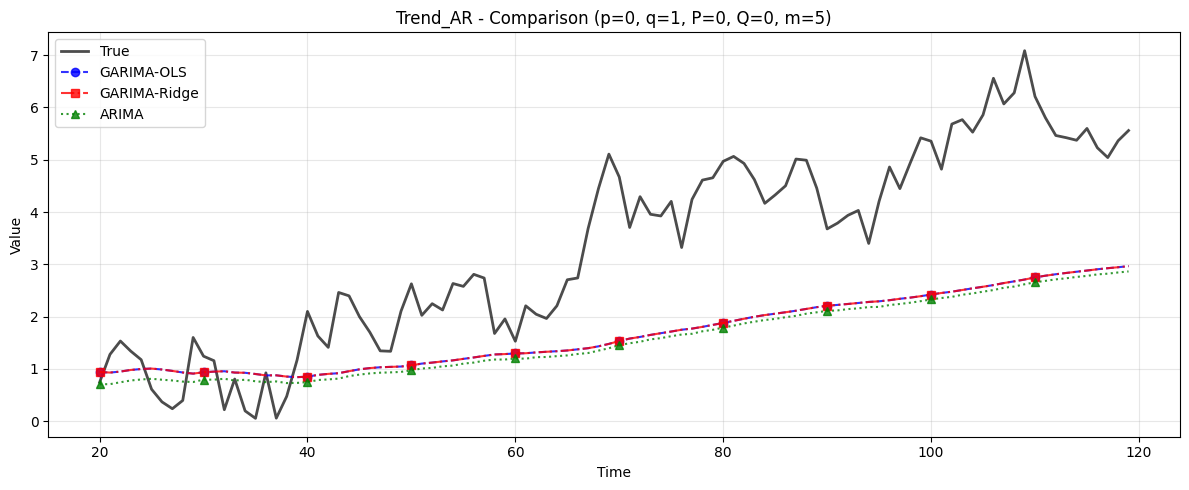


Trend_AR (p=0, q=1, P=0, Q=0):
  ARIMA           - MAE: 1.8315, RMSE: 2.1412, Time: 0.70s
  GARIMA-OLS      - MAE: 1.7560, RMSE: 2.0650, Time: 0.11s
  GARIMA-Ridge    - MAE: 1.7560, RMSE: 2.0650, Time: 0.16s



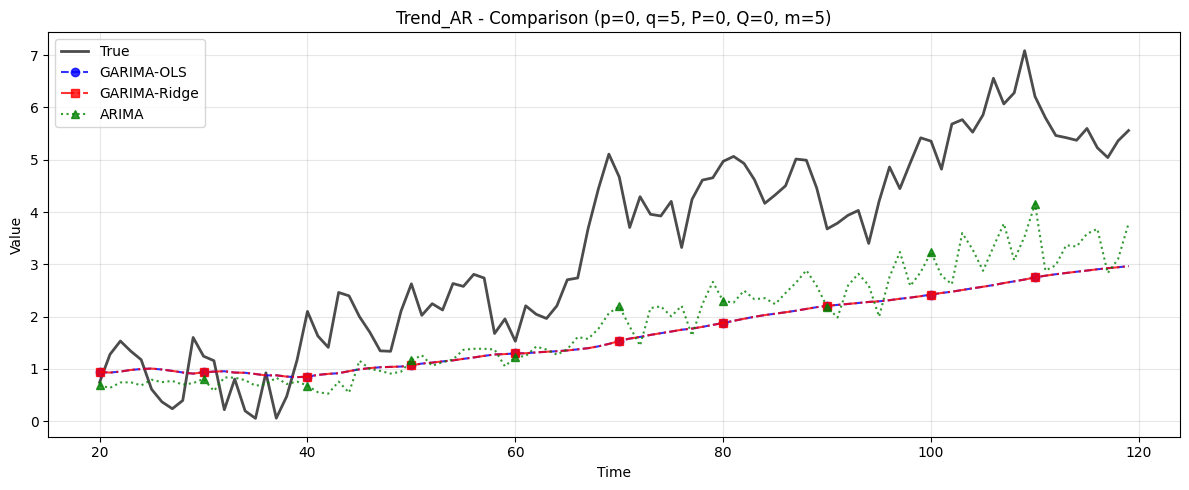


Trend_AR (p=0, q=5, P=0, Q=0):
  ARIMA           - MAE: 1.5345, RMSE: 1.7639, Time: 2.62s
  GARIMA-OLS      - MAE: 1.7560, RMSE: 2.0650, Time: 0.14s
  GARIMA-Ridge    - MAE: 1.7560, RMSE: 2.0650, Time: 0.15s



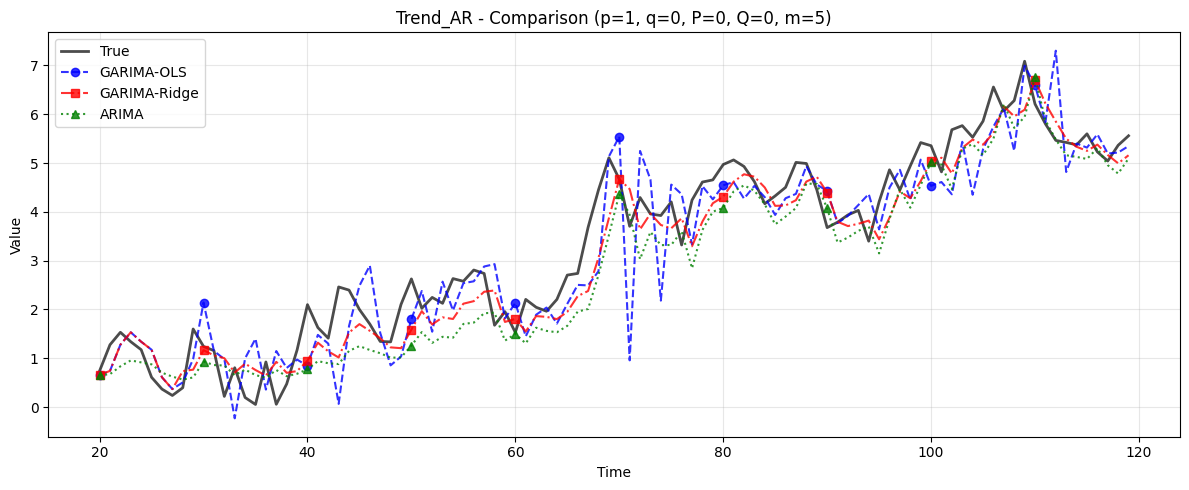


Trend_AR (p=1, q=0, P=0, Q=0):
  ARIMA           - MAE: 0.6058, RMSE: 0.7300, Time: 0.71s
  GARIMA-OLS      - MAE: 0.5627, RMSE: 0.7586, Time: 0.15s
  GARIMA-Ridge    - MAE: 0.4626, RMSE: 0.5726, Time: 0.20s



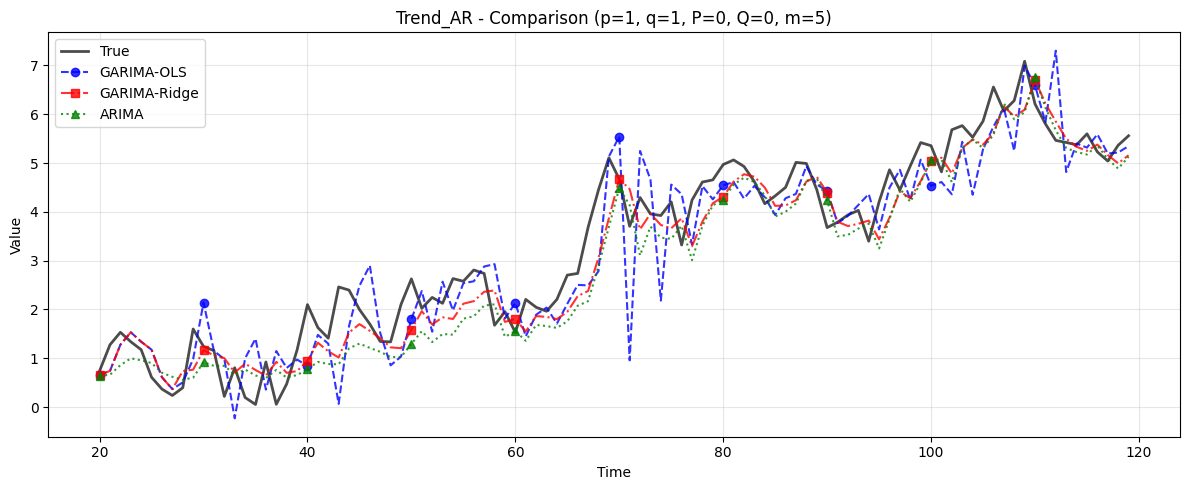


Trend_AR (p=1, q=1, P=0, Q=0):
  ARIMA           - MAE: 0.5646, RMSE: 0.6772, Time: 1.39s
  GARIMA-OLS      - MAE: 0.5627, RMSE: 0.7586, Time: 0.19s
  GARIMA-Ridge    - MAE: 0.4626, RMSE: 0.5726, Time: 0.26s



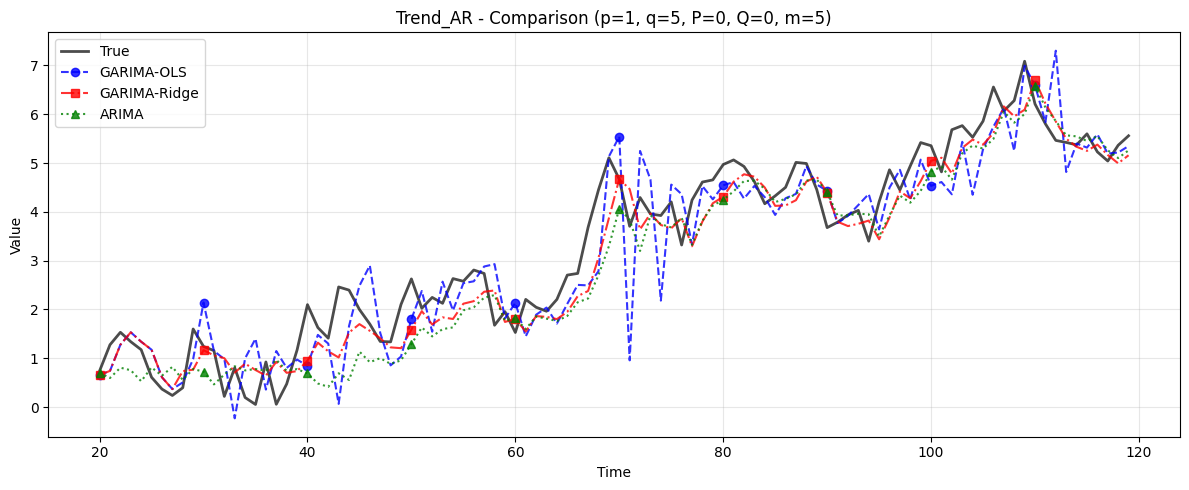


Trend_AR (p=1, q=5, P=0, Q=0):
  ARIMA           - MAE: 0.5720, RMSE: 0.7078, Time: 4.65s
  GARIMA-OLS      - MAE: 0.5627, RMSE: 0.7586, Time: 0.32s
  GARIMA-Ridge    - MAE: 0.4626, RMSE: 0.5726, Time: 0.42s



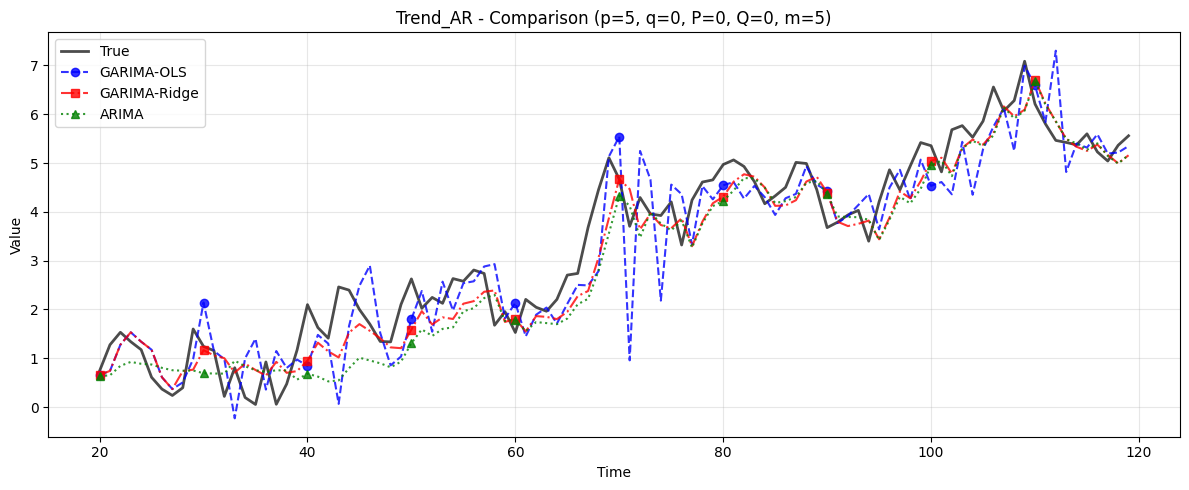


Trend_AR (p=5, q=0, P=0, Q=0):
  ARIMA           - MAE: 0.5675, RMSE: 0.6890, Time: 2.41s
  GARIMA-OLS      - MAE: 0.5627, RMSE: 0.7586, Time: 0.20s
  GARIMA-Ridge    - MAE: 0.4626, RMSE: 0.5726, Time: 0.23s



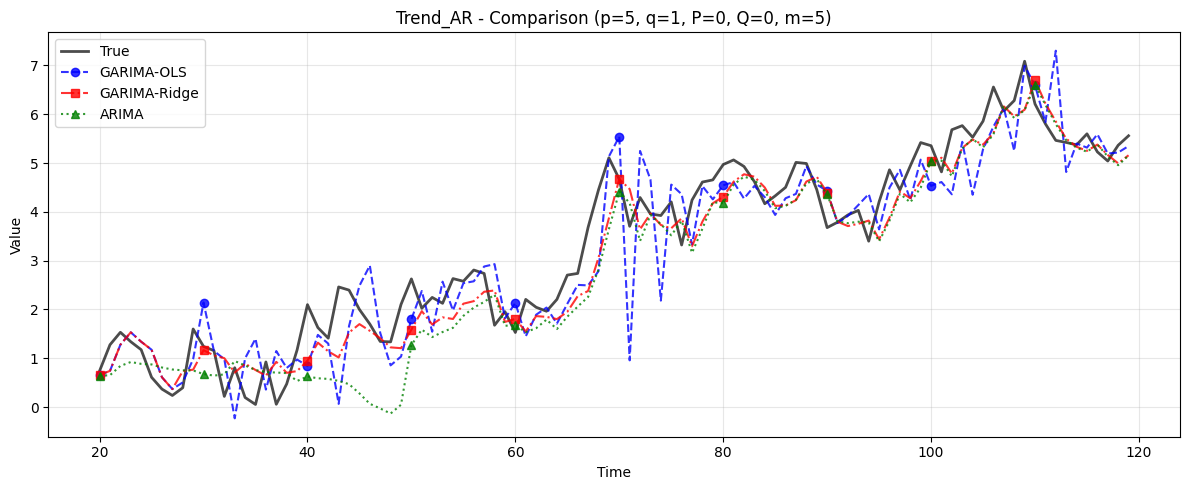


Trend_AR (p=5, q=1, P=0, Q=0):
  ARIMA           - MAE: 0.6203, RMSE: 0.7748, Time: 5.57s
  GARIMA-OLS      - MAE: 0.5627, RMSE: 0.7586, Time: 0.23s
  GARIMA-Ridge    - MAE: 0.4626, RMSE: 0.5726, Time: 0.28s



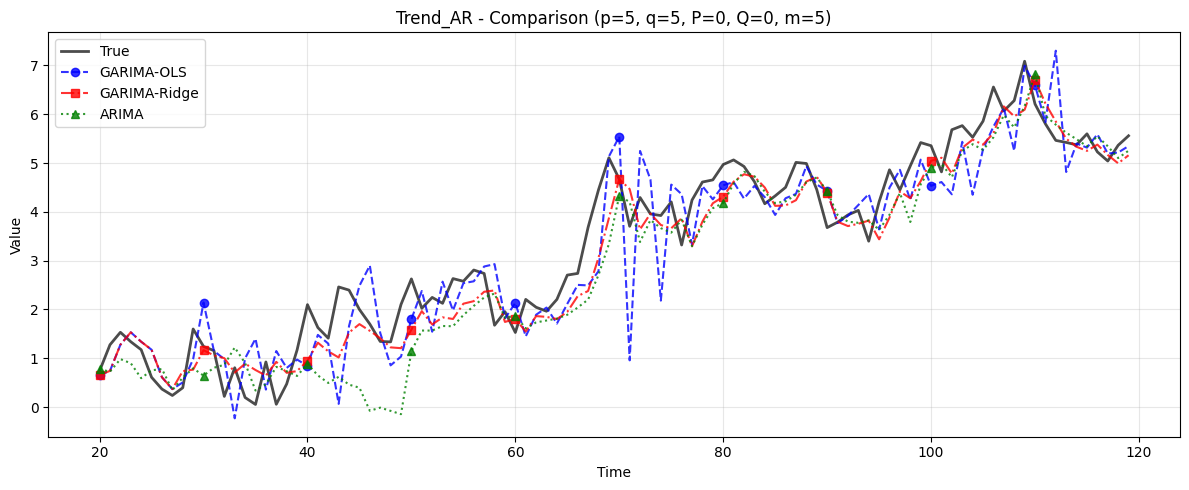


Trend_AR (p=5, q=5, P=0, Q=0):
  ARIMA           - MAE: 0.6195, RMSE: 0.7785, Time: 10.27s
  GARIMA-OLS      - MAE: 0.5627, RMSE: 0.7586, Time: 0.26s
  GARIMA-Ridge    - MAE: 0.4626, RMSE: 0.5726, Time: 0.30s



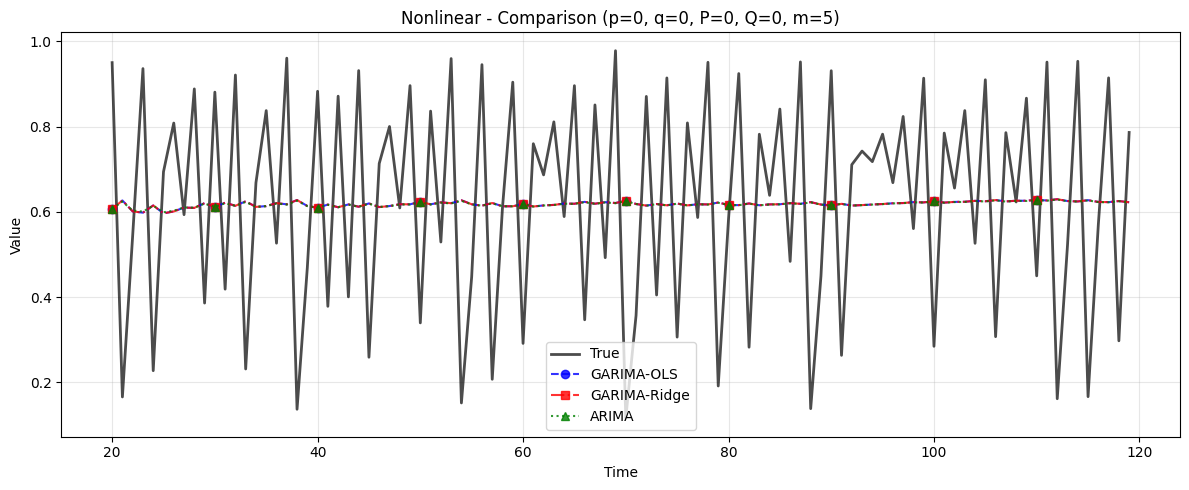


Nonlinear (p=0, q=0, P=0, Q=0):
  ARIMA           - MAE: 0.2322, RMSE: 0.2649, Time: 0.73s
  GARIMA-OLS      - MAE: 0.2324, RMSE: 0.2652, Time: 0.06s
  GARIMA-Ridge    - MAE: 0.2324, RMSE: 0.2652, Time: 0.07s



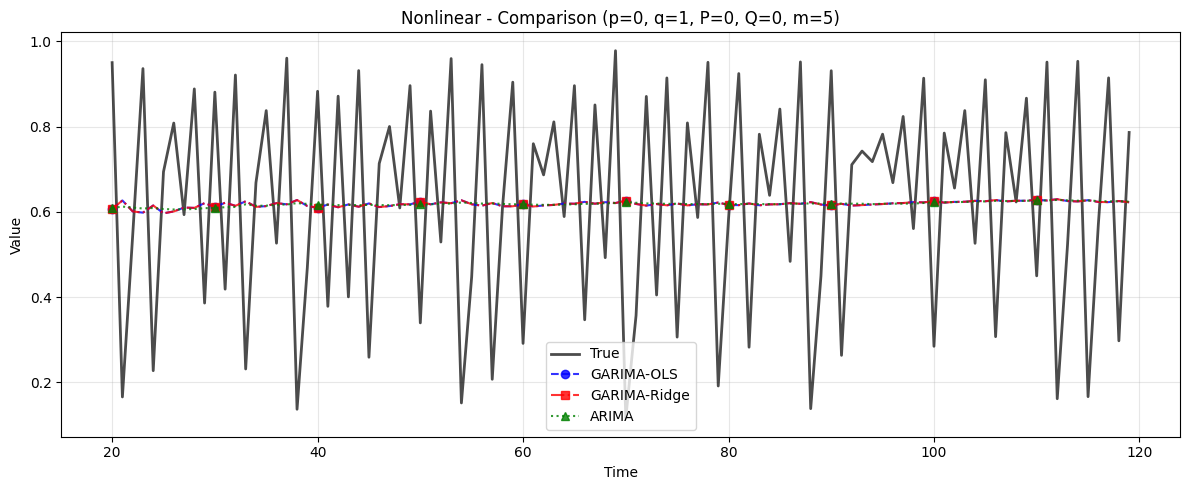


Nonlinear (p=0, q=1, P=0, Q=0):
  ARIMA           - MAE: 0.2307, RMSE: 0.2632, Time: 1.54s
  GARIMA-OLS      - MAE: 0.2324, RMSE: 0.2652, Time: 0.10s
  GARIMA-Ridge    - MAE: 0.2324, RMSE: 0.2652, Time: 0.16s



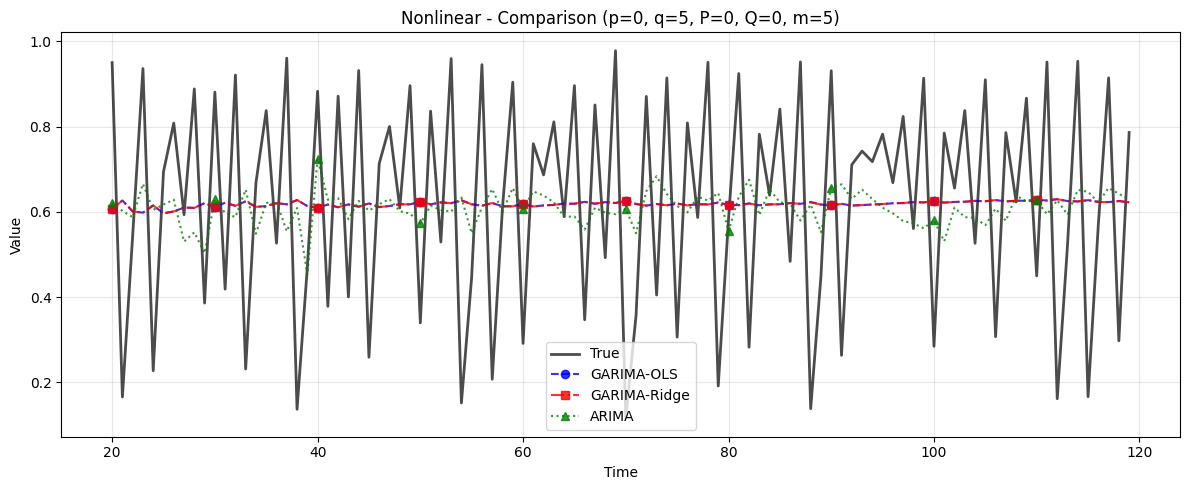


Nonlinear (p=0, q=5, P=0, Q=0):
  ARIMA           - MAE: 0.2272, RMSE: 0.2643, Time: 4.92s
  GARIMA-OLS      - MAE: 0.2324, RMSE: 0.2652, Time: 0.14s
  GARIMA-Ridge    - MAE: 0.2324, RMSE: 0.2652, Time: 0.15s



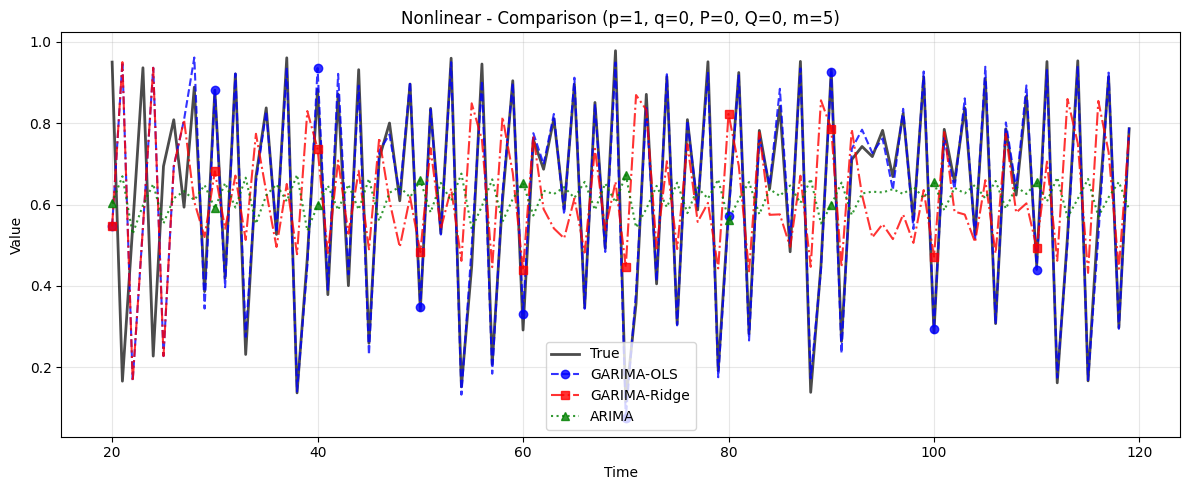


Nonlinear (p=1, q=0, P=0, Q=0):
  ARIMA           - MAE: 0.2469, RMSE: 0.2834, Time: 0.72s
  GARIMA-OLS      - MAE: 0.0521, RMSE: 0.1381, Time: 0.15s
  GARIMA-Ridge    - MAE: 0.2039, RMSE: 0.2466, Time: 0.21s



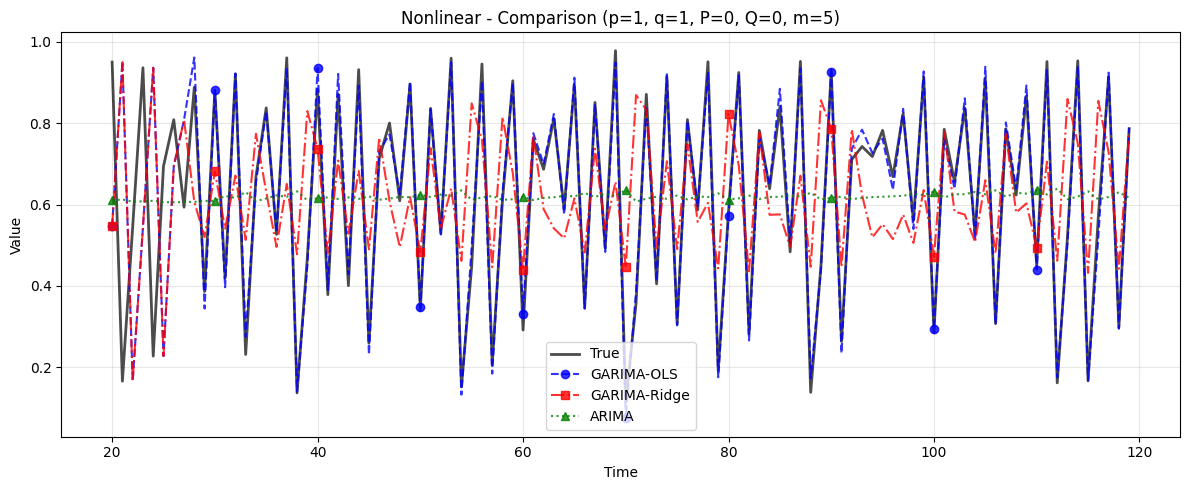


Nonlinear (p=1, q=1, P=0, Q=0):
  ARIMA           - MAE: 0.2326, RMSE: 0.2658, Time: 1.55s
  GARIMA-OLS      - MAE: 0.0521, RMSE: 0.1381, Time: 0.19s
  GARIMA-Ridge    - MAE: 0.2039, RMSE: 0.2466, Time: 0.26s



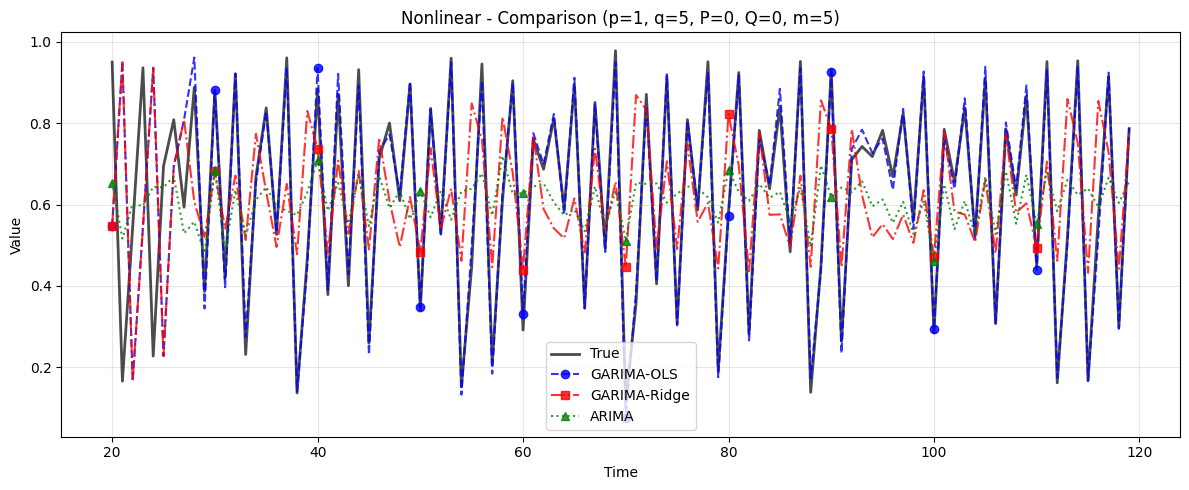


Nonlinear (p=1, q=5, P=0, Q=0):
  ARIMA           - MAE: 0.2128, RMSE: 0.2442, Time: 6.13s
  GARIMA-OLS      - MAE: 0.0521, RMSE: 0.1381, Time: 0.23s
  GARIMA-Ridge    - MAE: 0.2039, RMSE: 0.2466, Time: 0.28s



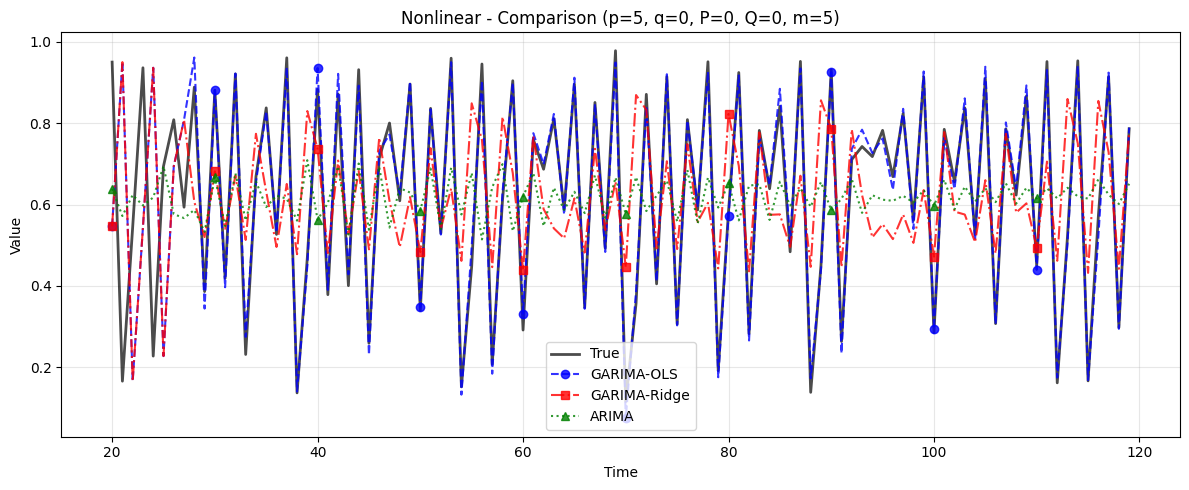


Nonlinear (p=5, q=0, P=0, Q=0):
  ARIMA           - MAE: 0.2193, RMSE: 0.2522, Time: 2.53s
  GARIMA-OLS      - MAE: 0.0521, RMSE: 0.1381, Time: 0.19s
  GARIMA-Ridge    - MAE: 0.2039, RMSE: 0.2466, Time: 0.23s



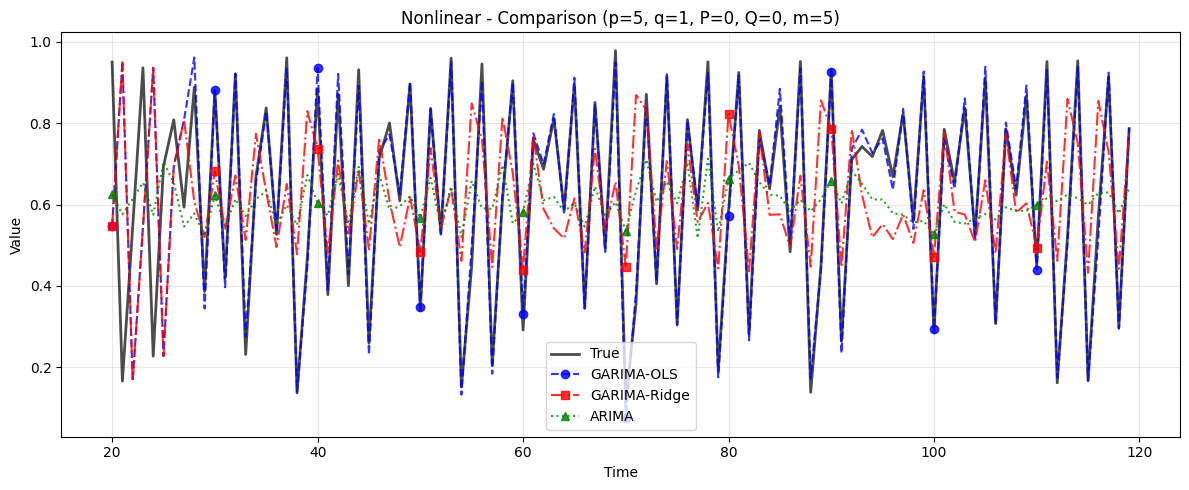


Nonlinear (p=5, q=1, P=0, Q=0):
  ARIMA           - MAE: 0.2129, RMSE: 0.2453, Time: 6.53s
  GARIMA-OLS      - MAE: 0.0521, RMSE: 0.1381, Time: 0.22s
  GARIMA-Ridge    - MAE: 0.2039, RMSE: 0.2466, Time: 0.28s



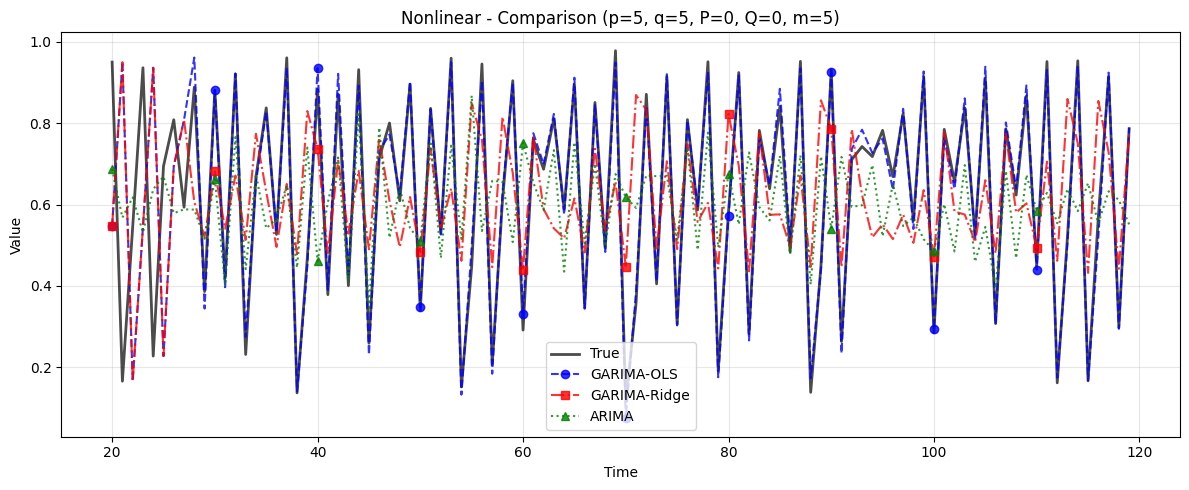


Nonlinear (p=5, q=5, P=0, Q=0):
  ARIMA           - MAE: 0.2089, RMSE: 0.2495, Time: 10.85s
  GARIMA-OLS      - MAE: 0.0521, RMSE: 0.1381, Time: 0.25s
  GARIMA-Ridge    - MAE: 0.2039, RMSE: 0.2466, Time: 0.29s



In [5]:

# Plot comparison of all three algorithms
for name, series in datasets.items():
    for p, q, P, Q in orders:
        y_true = series[window:window+horizon]
        
        plt.figure(figsize=(12, 5))
        plt.plot(range(window, window+horizon), y_true, 'k-', linewidth=2, label='True', alpha=0.7)
        
        # Plot each algorithm if it ran successfully
        colors = {'GARIMA-OLS': 'blue', 'GARIMA-Ridge': 'red', 'ARIMA': 'green'}
        markers = {'GARIMA-OLS': 'o', 'GARIMA-Ridge': 's', 'ARIMA': '^'}
        linestyles = {'GARIMA-OLS': '--', 'GARIMA-Ridge': '-.', 'ARIMA': ':'}
        
        for alg_name in ['GARIMA-OLS', 'GARIMA-Ridge', 'ARIMA']:
            key = (name, p, q, P, Q, alg_name)
            if key in first_run_preds:
                preds = first_run_preds[key]
                plt.plot(range(window, window+horizon), preds, 
                        color=colors[alg_name], 
                        linestyle=linestyles[alg_name],
                        marker=markers[alg_name],
                        markevery=10,
                        label=alg_name,
                        alpha=0.8)
        
        plt.title(f"{name} - Comparison (p={p}, q={q}, P={P}, Q={Q}, m={m_seasonal})")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Print error metrics for this dataset/order combo
        print(f"\n{name} (p={p}, q={q}, P={P}, Q={Q}):")
        subset = agg[(agg['Dataset'] == name) & 
                     (agg['p'] == p) & 
                     (agg['q'] == q) & 
                     (agg['P'] == P) & 
                     (agg['Q'] == Q)]
        if not subset.empty:
            for _, row in subset.iterrows():
                print(f"  {row['Alg']:15s} - MAE: {row['MAE']:.4f}, RMSE: {row['RMSE']:.4f}, Time: {row['combo_sec']:.2f}s")
        print()

SUMMARY: Algorithm Comparison

Overall Performance (averaged across all datasets):
         Alg      MAE     RMSE  combo_sec
GARIMA-Ridge 0.713564 0.863138   0.225467
       ARIMA 0.781563 0.949177   3.447747
  GARIMA-OLS 0.742321 0.971393   0.180444

Best Algorithm Per Dataset (by RMSE):

Noisy_ARMA:
  Winner: GARIMA-Ridge
  MAE: 1.1622, RMSE: 1.4205
  All algorithms:
    GARIMA-Ridge   : MAE=1.1622, RMSE=1.4205 ✓
    ARIMA          : MAE=1.2842, RMSE=1.6001   (+12.6%)
    GARIMA-OLS     : MAE=1.2709, RMSE=1.7542   (+23.5%)

Seasonal:
  Winner: GARIMA-Ridge
  MAE: 0.5849, RMSE: 0.7092
  All algorithms:
    GARIMA-Ridge   : MAE=0.5849, RMSE=0.7092 ✓
    GARIMA-OLS     : MAE=0.6257, RMSE=0.7569   (+6.7%)
    ARIMA          : MAE=0.6446, RMSE=0.7806   (+10.1%)

Trend_AR:
  Winner: GARIMA-Ridge
  MAE: 0.8937, RMSE: 1.0701
  All algorithms:
    GARIMA-Ridge   : MAE=0.8937, RMSE=1.0701 ✓
    ARIMA          : MAE=0.9726, RMSE=1.1568   (+8.1%)
    GARIMA-OLS     : MAE=0.9605, RMSE=1.1941   (+

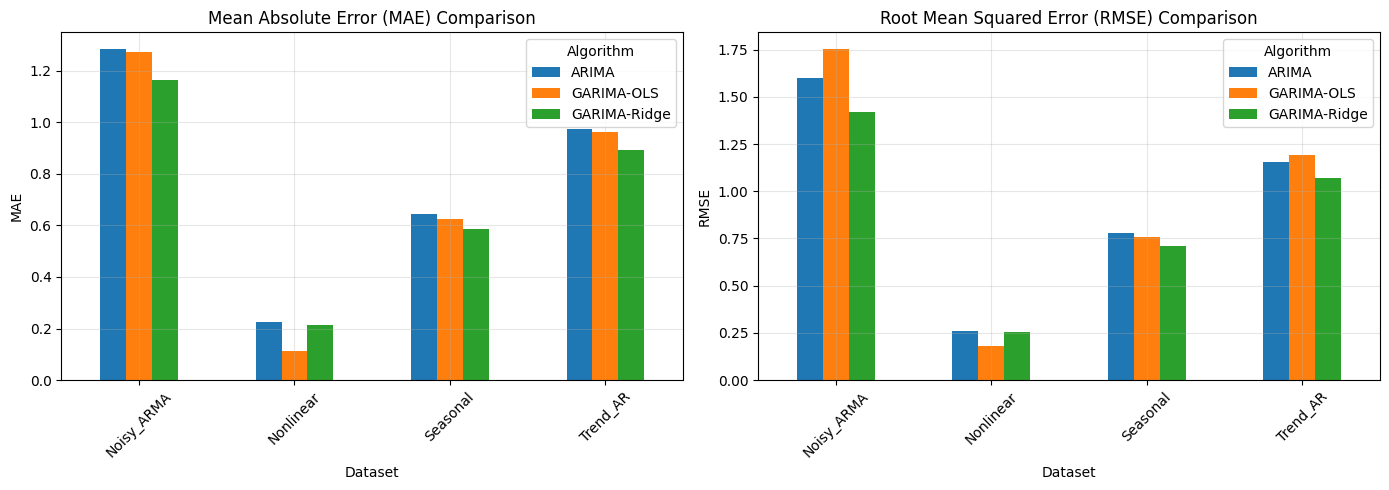


Computational Efficiency:
         Alg  mean_iter_ms  combo_sec  throughput_iters_per_sec
  GARIMA-OLS      1.804273   0.180444                670.061407
GARIMA-Ridge      2.254489   0.225467                537.467466
       ARIMA     34.477186   3.447747                 69.692284


In [6]:
# Summary comparison across all algorithms
print("="*70)
print("SUMMARY: Algorithm Comparison")
print("="*70)

# Overall average across all datasets
overall = df.groupby('Alg', as_index=False)[['MAE', 'RMSE', 'combo_sec']].mean()
overall = overall.sort_values('RMSE')

print("\nOverall Performance (averaged across all datasets):")
print(overall.to_string(index=False))

# Best performer per dataset
print("\n" + "="*70)
print("Best Algorithm Per Dataset (by RMSE):")
print("="*70)

for dataset in df['Dataset'].unique():
    dataset_df = df[df['Dataset'] == dataset]
    best = dataset_df.groupby('Alg', as_index=False)[['MAE', 'RMSE']].mean()
    best = best.sort_values('RMSE')
    winner = best.iloc[0]
    
    print(f"\n{dataset}:")
    print(f"  Winner: {winner['Alg']}")
    print(f"  MAE: {winner['MAE']:.4f}, RMSE: {winner['RMSE']:.4f}")
    print(f"  All algorithms:")
    for _, row in best.iterrows():
        improvement = ((best.iloc[0]['RMSE'] - row['RMSE']) / best.iloc[0]['RMSE']) * 100 if row['Alg'] != winner['Alg'] else 0
        status = "✓" if row['Alg'] == winner['Alg'] else f"  (+{-improvement:.1f}%)"
        print(f"    {row['Alg']:15s}: MAE={row['MAE']:.4f}, RMSE={row['RMSE']:.4f} {status}")

# Create bar plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAE comparison
mae_pivot = df.groupby(['Dataset', 'Alg'])['MAE'].mean().reset_index().pivot(
    index='Dataset', columns='Alg', values='MAE'
)
mae_pivot.plot(kind='bar', ax=axes[0], rot=45)
axes[0].set_title('Mean Absolute Error (MAE) Comparison')
axes[0].set_ylabel('MAE')
axes[0].legend(title='Algorithm', loc='best')
axes[0].grid(True, alpha=0.3)

# RMSE comparison
rmse_pivot = df.groupby(['Dataset', 'Alg'])['RMSE'].mean().reset_index().pivot(
    index='Dataset', columns='Alg', values='RMSE'
)
rmse_pivot.plot(kind='bar', ax=axes[1], rot=45)
axes[1].set_title('Root Mean Squared Error (RMSE) Comparison')
axes[1].set_ylabel('RMSE')
axes[1].legend(title='Algorithm', loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Timing comparison
print("\n" + "="*70)
print("Computational Efficiency:")
print("="*70)
timing = df.groupby('Alg', as_index=False)[['mean_iter_ms', 'combo_sec', 'throughput_iters_per_sec']].mean()
timing = timing.sort_values('combo_sec')
print(timing.to_string(index=False))
